In [97]:
#scientific libraries and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

#torch specific
import torch
import torchvision as torchv
import torch.optim as optim

#other libraries
import time
import sys
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import atlas_mpl_style as ampl

#Using newest versions of all libraries

In [98]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from resnet import ResNet18
from imcal import *
from imcal import Hdf5Dataset
from imcal import RandomRoll
from imcal import CircularPadding

In [99]:
#variables controlled by the user. Change these to fit your specific needs.

TRAIN_N_EVENTS = 18000 #Number of events to process for each class.
VAL_N_EVENTS = 2000 #Number of events to process for each class.
#TEST_N_EVENTS = 6000 #Number of events to process for each class.
RES = 50 #resolution
CUT=True #Should cut be applied? Chooses different files if True.

#Data specification
LABELS = ["BH_n2_M12", "BH_n3_M12", "BH_n4_M12", "BH_n5_M12", "BH_n6_M12"]
PLOT_LABELS = ["n2_M12", "n3_M12", "n4_M12", "n5_M12", "n6_M12"]
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["BH", "BH", "BH", "BH", "BH"]

# LABELS = ["BH_n4_M8", "BH_n4_M10", "BH_n4_M12"]
# PLOT_LABELS = ["BH_n4_M8", "BH_n4_M10", "BH_n4_M12"]
# CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
# FOLDERS = ["BH", "BH", "BH"]

#Set data paths
if CUT:
    N_EVENTS = 20000
    TRAIN_FILENAMES = [f"{label}_res{RES}_STmin7_Nmin5_{N_EVENTS}_events.h5" for label in LABELS]
    #TEST_FILENAMES = [f"{label}_res{RES}_STmin7_Nmin5_15000_events.h5" for label in LABELS]
    VAL_FILENAMES = [f"{label}_res{RES}_STmin7_Nmin5_{N_EVENTS}_events.h5" for label in LABELS]
else:
    N_EVENTS = 40000
    TRAIN_FILENAMES = [f"{label}_res{RES}_{N_EVENTS}_events.h5" for label in LABELS]
    #TEST_FILENAMES = [f"{label}_res{RES}_3000_events.h5" for label in LABELS]
    VAL_FILENAMES = [f"{label}_res{RES}_{N_EVENTS}_events.h5" for label in LABELS]

TRAIN_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TRAIN_FILENAMES[i]}" for i in range(CLASSES)]
VAL_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{VAL_FILENAMES[i]}" for i in range(CLASSES)]
#TEST_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TEST_FILENAMES[i]}" for i in range(CLASSES)]

#Set a unique name for the model
labelstring = '_'.join([str(elem) for elem in PLOT_LABELS])
if CUT:
    MODEL_NAME = f"resnet_{str(int(time.time()))}_{labelstring}_CUT_res{RES}"
else: MODEL_NAME = f"resnet_{str(int(time.time()))}_{labelstring}"
print(MODEL_NAME)
#Where to save the model
SAVE_FOLDER = "../results/models"
SAVE_PATH = f"{SAVE_FOLDER}/{MODEL_NAME}.pt"

#Setup GPU if available
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    torch.cuda.empty_cache()
    print("Running on the GPU")
else:
    DEVICE = torch.device("cpu")
    print("Running on the CPU")

#Data processing
filters=[None]
transforms = torch.nn.Sequential(
        torchv.transforms.RandomVerticalFlip(),
        #CircularPadding(20, 0)
        RandomRoll(roll_axis=0)
    )
#For plotting
ampl.use_atlas_style()   

resnet_1719319225_n2_M12_n3_M12_n4_M12_n5_M12_n6_M12_CUT_res50
Running on the GPU


### Load data

In [100]:
#Load data

#testpaths = [Path(path) for path in TEST_DATAPATHS]
trainpaths = [Path(path) for path in TRAIN_DATAPATHS]
valpaths = [Path(path) for path in VAL_DATAPATHS]

"""#Load lazily to save memory
test_data = Hdf5Dataset(testpaths, TEST_LABELS, DEVICE, 
                        shuffle=False, filters=filters, transform=None, event_limit=TEST_N_EVENTS)
val_data = Hdf5Dataset(valpaths, TEST_LABELS, DEVICE, 
                        shuffle=True, filters=filters, transform=None, event_limit=VAL_N_EVENTS)
train_data = Hdf5Dataset(trainpaths, LABELS, DEVICE, 
                        shuffle=True, filters=filters, transform=transforms, event_limit=TRAIN_N_EVENTS)
"""
#Load directly to speed up
#test_data = load_datasets(testpaths, DEVICE, TEST_N_EVENTS, filters, transforms=transforms)
print(TRAIN_N_EVENTS + 0)
train_data = load_datasets(trainpaths, DEVICE, TRAIN_N_EVENTS, filters, transforms=transforms, start_index = 0)
val_data = load_datasets(valpaths, DEVICE, VAL_N_EVENTS, filters, transforms=None, start_index = TRAIN_N_EVENTS)


18000
Loads data with transforms Sequential(
  (0): RandomVerticalFlip(p=0.5)
  (1): RandomRoll()
) and filters [None]


Loaded data with 18000 entries of shape (18000, 50, 50, 3).
Check max value: 21514.287109375.
Check max value: 21514.287109375.
Loaded data with 18000 entries of shape (18000, 50, 50, 3).
Check max value: 35149.4140625.
Check max value: 35149.4140625.
Loaded data with 18000 entries of shape (18000, 50, 50, 3).
Check max value: 30125.650390625.
Check max value: 30125.650390625.
Loaded data with 18000 entries of shape (18000, 50, 50, 3).
Check max value: 52001.9453125.
Check max value: 52001.9453125.
Loaded data with 18000 entries of shape (18000, 50, 50, 3).
Check max value: 53828.987749904394.
Check max value: 53828.987749904394.
Data has shape torch.Size([50, 50, 3])
There are 5 classes.
Loads data with transforms None and filters [None]
Loaded data with 2000 entries of shape (2000, 50, 50, 3).
Check max value: 14243.29296875.
Check max value: 14243.29296875.
Loaded data with 2000 entries of shape (2000, 50, 50, 3).
Check max value: 27243.88671875.
Check max value: 27243.88671875.
Loa

In [101]:
print(val_data[0][0].shape)

torch.Size([50, 50, 3])


### View the data

Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n2_M12_res50_STmin7_Nmin5_20000_events.h5.
Selecting 1000 events out of 20000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n3_M12_res50_STmin7_Nmin5_20000_events.h5.
Selecting 1000 events out of 20000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M12_res50_STmin7_Nmin5_20000_events.h5.
Selecting 1000 events out of 20000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n5_M12_res50_STmin7_Nmin5_20000_events.h5.
Selecting 1000 events out of 20000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n6_M12_res50_STmin7_Nmin5_20000_events.h5.
Selecting 1000 events out of 20000.


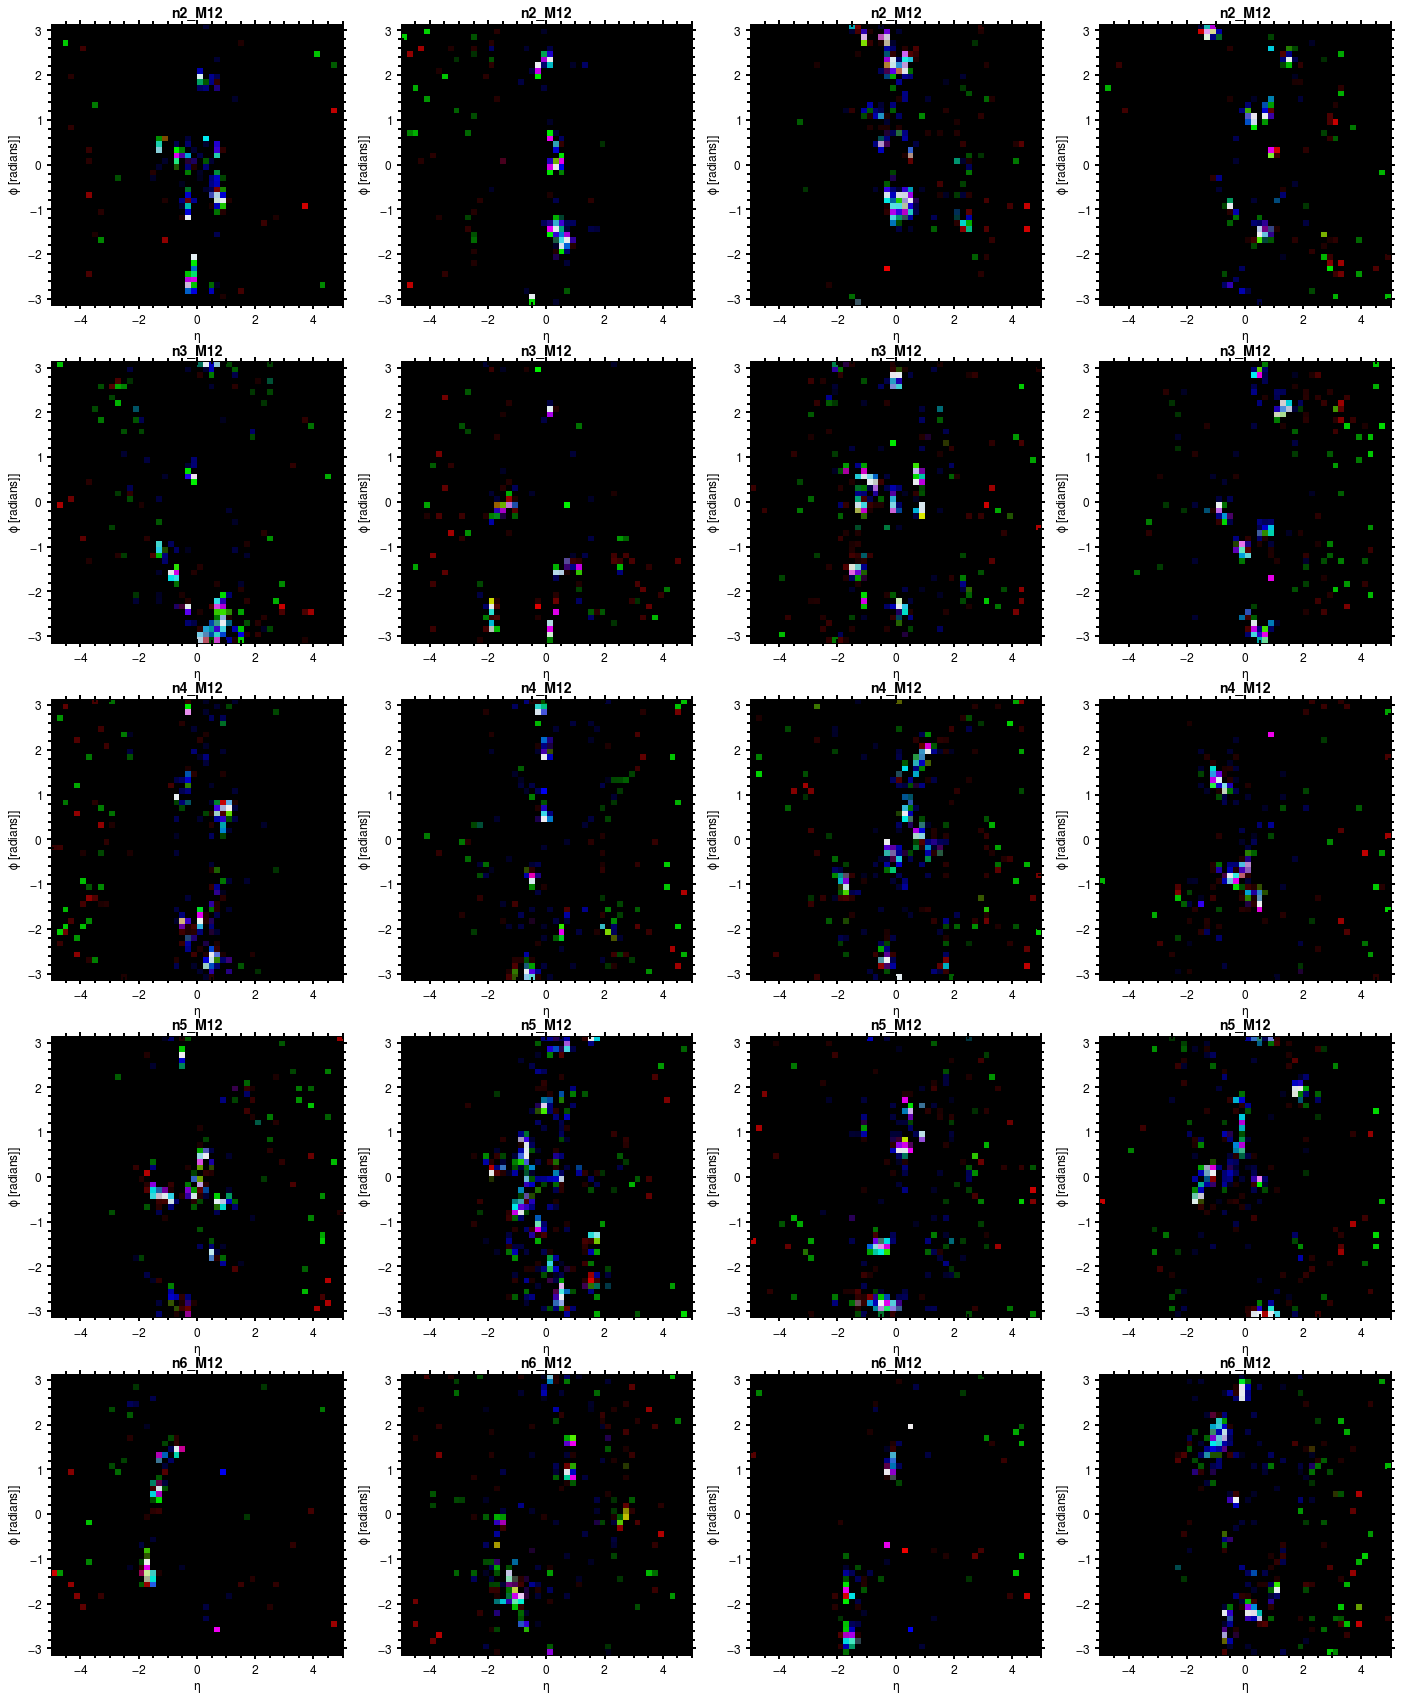

In [102]:
#Print some of the images
inspect_data = Hdf5Dataset(trainpaths, LABELS, DEVICE, max_value=70, 
                        shuffle=False, filters=["paper"], transform=None, event_limit=1000)
view_data(inspect_data, 4, CLASSES, PLOT_LABELS, RES, 1000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Look at the highest histogram values values for a random image
[ 296.2276   297.40747  379.70108  490.6639   616.4218   662.20654
  843.06726  858.4204  1120.7382 ]
Looking at image 0


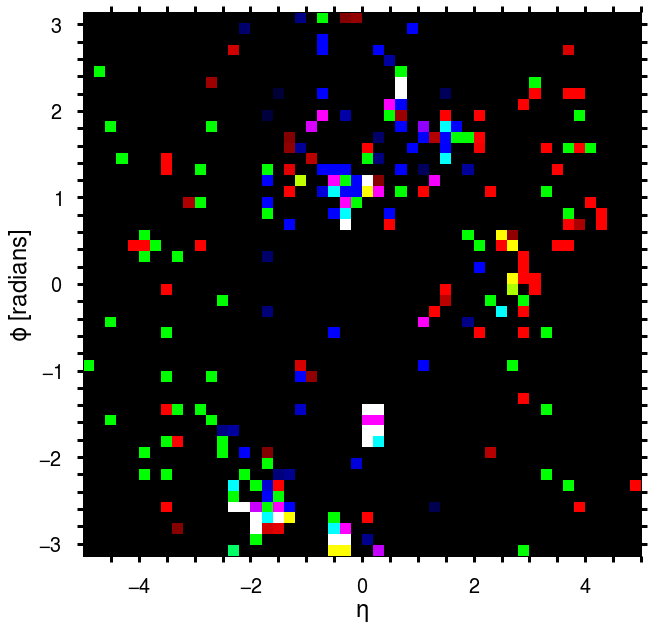

In [103]:
#Look at an image more closely
image = val_data[-1][0].cpu()
print("Look at the highest histogram values values for a random image")
print(np.sort(image.flatten())[-10:-1])
print("Looking at image", 0)

fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
ax.imshow(image, extent=[-5, 5, -np.pi, np.pi], aspect='auto')
cal_image_plot_paper(ax)
ax.tick_params(which="both", direction="out", bottom=True, left=True, labelsize=20, pad=15, length=6, width=3)

In [104]:
#Check augmentation on the same image
#if transforms!=None:
#    rolled_image = transforms(image)
#    plt.imshow(rolled_image)

### Create net and train

In [159]:
#Create NN.
resnet = ResNet50(img_channels=3, num_classes=CLASSES)
resnet.to(DEVICE)
#Test that nothing major is wrong.
testimage, testlabel = val_data[0][0], val_data[0][1]
print(testimage.shape)
testimage = torch.swapaxes(testimage, -3, -1)
print(testimage.shape)
print(-1, 3, testimage.shape[-2], testimage.shape[-1])
print(resnet(testimage.view(-1, 3, testimage.shape[-2], testimage.shape[-1]).to(DEVICE)))
print(testlabel)

torch.Size([50, 50, 3])
torch.Size([3, 50, 50])
-1 3 50 50
tensor([[-7.2300e-04,  5.8308e-02,  4.3872e-01, -1.9786e-01,  1.2133e+00]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([1., 0., 0., 0., 0.], device='cuda:0')


In [160]:
#Set optimizer, learning rate scheduler and train the model
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
#scheduler = optim.lr_scheduler.CyclicLR(optimizer, 0.0001, 0.01, cycle_momentum=False)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.1, max_lr=0.1*10, step_size_up=5, mode="exp_range", gamma=0.85, cycle_momentum=False)
training_results = train(resnet, train_data, val_data, 2**9, 15, RES, DEVICE, optimizer, scheduler)

100%|██████████| 15/15 [07:35<00:00, 30.38s/it]


In [161]:
#Test that nothing major is wrong after training.
k = np.random.randint(0, len(val_data))
testimage, testlabel = val_data[k][0], val_data[k][1]
testimage = torch.swapaxes(testimage, -3, -1)
print(testimage.view(-1, 3, testimage.shape[-2], testimage.shape[-1]).shape)
print(resnet(testimage.view(-1, 3, testimage.shape[-2], testimage.shape[-1]).to(DEVICE)), testlabel)

torch.Size([1, 3, 50, 50])
tensor([[-0.4871,  0.0338,  0.4446,  0.5480,  0.7197]], device='cuda:0',
       grad_fn=<AddmmBackward0>) tensor([0., 0., 0., 1., 0.], device='cuda:0')


### Inspect the results

(0.0, 1.8)

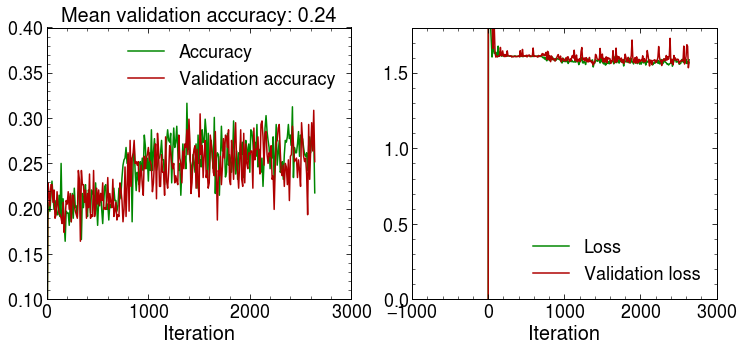

In [162]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
training_results.plot("Iteration", ["Accuracy", "Validation accuracy"], ax=axs[0], 
                    title="Mean validation accuracy: " + str(round(training_results["Validation accuracy"].mean(), 2)))
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[1])
axs[0].set_ylim(0.1, 0.4)
axs[0].set_xlim(0)
axs[1].set_ylim(0, 1.8)

### Predict on test set and check accuracy

In [163]:
truth, preds, losses, values = predict(resnet, val_data, CLASSES, 100, RES, DEVICE, return_loss=True, return_conf=True)
confusion = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))
accuracy = accuracy_score(truth, preds, normalize=True)

100%|██████████| 100/100 [00:01<00:00, 78.81it/s]


In [164]:
#Save model
#torch.save(resnet.state_dict(), SAVE_PATH)

[0.599 0.092 0.118 0.    0.191 0.43  0.101 0.144 0.    0.324 0.364 0.093
 0.148 0.    0.394 0.303 0.087 0.147 0.    0.463 0.253 0.082 0.134 0.
 0.532]


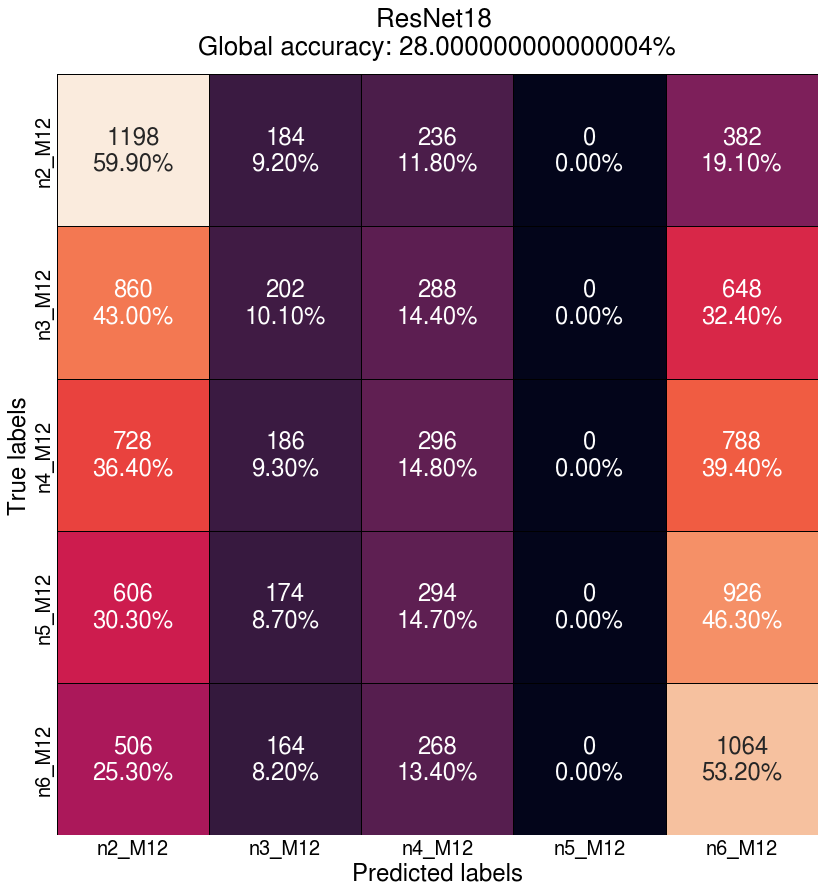

In [165]:
def plot_conf_matrix(confusion, accuracy, labels):
    """
    plot confusion matrix
    """
    fig, ax = plt.subplots(1,1, figsize=(14, 14))

    #Generate the confusion matrix
    cf_matrix = confusion_matrix(confusion["Truth"], confusion["Predictions"], normalize="true")
    cf_matrix = np.round(cf_matrix, 3)
    print(cf_matrix.flatten())
    group_counts = ["{0:0.0f}".format(value*VAL_N_EVENTS) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()]
    annot = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    annot = np.asarray(annot).reshape(len(labels),len(labels))
    sn.heatmap(
            cf_matrix, 
            ax=ax, 
            annot=annot, 
            cmap='rocket', 
            linewidths=1.0, 
            linecolor='black',
            cbar = False, 
            square=True, 
            fmt='', 
            cbar_kws={'format':'%.0f'},
            annot_kws={"size": 24}
        )

    #ax.set_title('Confusion matrix\n\n', size=24)
    ax.set_xlabel('Predicted labels', size=24)
    ax.set_ylabel('True labels', size=24)

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(labels, size=20)
    ax.yaxis.set_ticklabels(labels, size=20)
    ax.tick_params(which="both", left=False, bottom=False, top=False, right=False)
    ax.set_title(f"ResNet18 \nGlobal accuracy: {round(accuracy, 2)*100}%", size=26, pad=20)

    ## Display the visualization of the Confusion Matrix.
    plt.show()
plot_conf_matrix(confusion, accuracy, PLOT_LABELS)